# Abalone Regression Project

## Task

Predict the age of the abalone from physical measurements only

## Problem

The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- it is a tedious, expensiveand time-consuming task.

## Solution

Creating a machine learning algorithm that will predict the age of the abalone using physical measurements only

## Dataset Information

- 8 attributes
- 4177 instances
---
- ***`Name` / Data Type / Measurement Unit / Description***

- `Sex` - nominal / -- / M, F, and I (infant)
- `Length` - continuous / mm / Longest shell measurement
- `Diameter` - continuous / mm / perpendicular to length
- `Height` - continuous / mm / with meat in shell
- `Whole weight` - continuous / grams / whole abalone
- `Shucked weight` - continuous / grams / weight of meat
- `Viscera weight` - continuous / grams / gut weight (after bleeding)
- `Shell weight` - continuous / grams / after being dried
- `Rings` - integer / -- / +1.5 gives the age in years

---

In [2]:
#conda install -c conda-forge pandas-profiling

In [3]:
#conda install -c conda-forge lightgbm

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pandas_profiling import ProfileReport

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline

## Import Data

In [5]:
datapath = '/Users/tahermn/Documents/Programming/Data Science Portfolio/ds portfolio editing/Abalone Regression Age Prediction/abalone_data.data'

df = pd.read_csv(datapath, header = None, index_col=False)
df.columns = [
    'sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings'
]
df.head()

sex  length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   shell_weight  rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

## Exploratory Data Analysis (EDA)

In [6]:
profile = ProfileReport(df)
profile

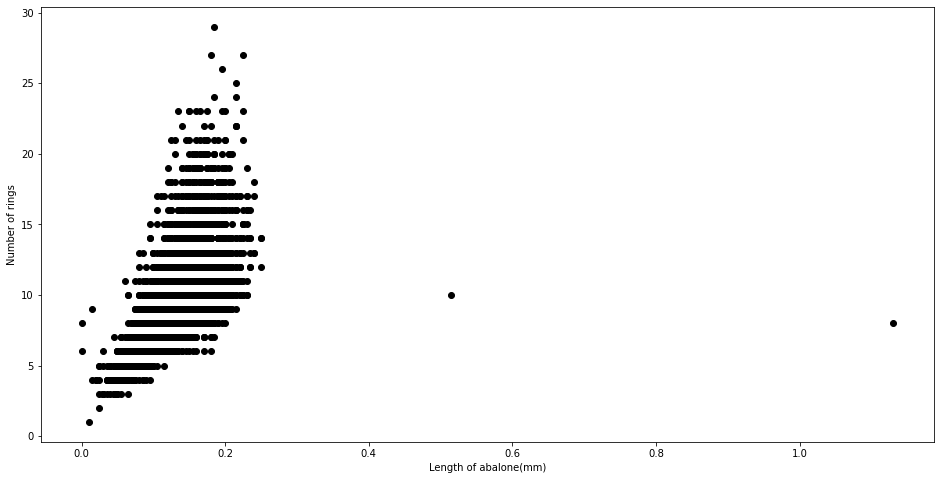

In [7]:
plt.figure(figsize = (16,8))
plt.scatter(df.height, df.rings, c = 'black')
plt.xlabel('Length of abalone(mm)')
plt.ylabel('Number of rings')
plt.show()

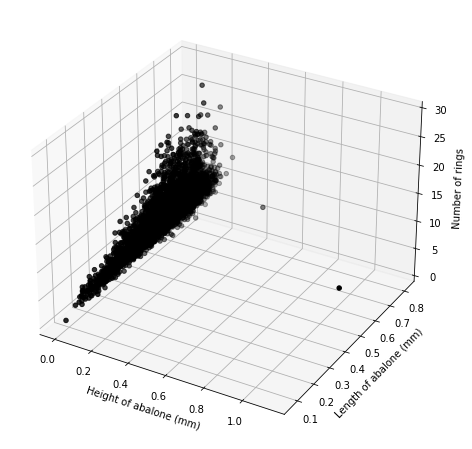

In [8]:
fig = plt.figure(figsize = (16,8))
ax = plt.axes(projection = '3d')

ax.set_xlabel('Height of abalone (mm)')
ax.set_ylabel('Length of abalone (mm)')
ax.set_zlabel('Number of rings')
ax.scatter3D(df['height'], df['length'], df['rings'], c = 'black')

## Feature Engineering

### One-Hot Encoding

In [9]:
encoded_data = pd.get_dummies(df)
encoded_data.head()
print(encoded_data.shape)

(4177, 11)


## Modeling

### Split dataset

In [10]:
training_set = encoded_data.iloc[:4099, :]
validation_set = encoded_data.iloc[4099:, :]

print(training_set.shape)
print(validation_set.shape)

(4099, 11)
(78, 11)


### Baseline model: Multiple Linear Regression

In [11]:
X = training_set[['length', 'height']]
y = training_set['rings'].values.reshape(-1, 1)

X_val = validation_set[['length', 'height']]
y_val = validation_set['rings'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [12]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

# Test RMSE
lin_reg_pred = lin_reg.predict(X_test)
lin_reg_test_rmse = mean_squared_error(y_test, lin_reg_pred, squared = False)
print(f'Test RMSE: {lin_reg_test_rmse}')

# Validation RMSE
lin_reg_pred_val = lin_reg.predict(X_val)
lin_reg_val_rmse = mean_squared_error(y_val, lin_reg_pred_val, squared = False)
print(f'Validation RMSE: {lin_reg_val_rmse}')

Test RMSE: 2.5679099174951547
Validation RMSE: 1.5661783782311625


### Multiple Linear Regression with regularization (Ridge Regression)

In [13]:
ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters, scoring = 'neg_root_mean_squared_error', cv = 5)

ridge_regressor.fit(X_train, y_train);

print(ridge_regressor.best_params_)
print(-ridge_regressor.best_score_)

{'alpha': 1}
2.6564563658448885


In [14]:
ridge_reg = Ridge(alpha = 1)
ridge_reg.fit(X_train, y_train)

ridge_reg_pred = ridge_reg.predict(X_test)

#Test RMSE
ridge_reg_test_rmse = mean_squared_error(y_test, ridge_reg_pred, squared = False)
print(f'Test RMSE: {ridge_reg_test_rmse}')

#Validation RMSE
ridge_reg_pred_val = ridge_reg.predict(X_val)
ridge_reg_val_rmse = mean_squared_error(y_val, ridge_reg_pred_val, squared = False)
print(f'Validation RMNSE: {ridge_reg_val_rmse}')


Test RMSE: 2.5871300097108296
Validation RMNSE: 1.5640813253014876


In [15]:
### Multiple Linear Regression with Regularization (Lasso)
lasso = Lasso(tol = 0.05)

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 5)

lasso_regressor.fit(X_train, y_train)

print(lasso_regressor.best_params_)
print(-lasso_regressor.best_score_)

{'alpha': 1}
7.074168080611119


In [16]:
lasso_reg = Lasso(alpha = 1)
lasso_reg.fit(X_train, y_train)

lasso_reg_pred = lasso_reg.predict(X_test)

#Test RMSE
lasso_reg_test_rmse = mean_squared_error(y_test, lasso_reg_pred, squared = False)
print(f'Test RMSE: {lasso_reg_test_rmse}')

#Validation RMSE
lasso_reg_pred_val = lasso_reg.predict(X_val)
lasso_reg_val_rmse = mean_squared_error(y_val, lasso_reg_pred_val, squared = False)
print(f'Validation RMNSE: {lasso_reg_val_rmse}')

Test RMSE: 3.2315518915511485
Validation RMNSE: 1.8892343923959762


 ## Tree based models

In [17]:
X = training_set.drop(['rings', 'diameter', 'whole_weight', 'shucked_weight',
                       'viscera_weight', 'shell_weight'], axis = 1)
y = training_set['rings'].values.reshape(-1, 1)

X_val = validation_set.drop(['rings', 'diameter', 'whole_weight', 'shucked_weight',
                       'viscera_weight', 'shell_weight'], axis = 1)
y_val = validation_set['rings'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

### Random Forest

In [18]:
rf = RandomForestRegressor()

parameters = {'n_estimators': [int(x) for x in np.linspace(100, 1000, 10)]}

rf_regressor = GridSearchCV(rf, parameters, scoring = 'neg_mean_squared_error', cv = 5)

rf_regressor.fit(X_train, y_train.ravel())

print(rf_regressor.best_params_)
print(-rf_regressor.best_score_)

{'n_estimators': 700}
8.392270806067234


In [19]:
rf_reg = RandomForestRegressor(n_estimators = 800)
rf_reg.fit(X_train, y_train.ravel())

#Test RMSE
rf_reg_pred = rf_reg.predict(X_test)
rf_reg_test_rmse = mean_squared_error(y_test, rf_reg_pred, squared = False)

print(f'Test RMSE: {rf_reg_test_rmse}')

#Validation RMSE
rf_reg_pred_val = rf_reg.predict(X_val)
rf_reg_val_rmse = mean_squared_error(y_val, rf_reg_pred_val, squared = False)

print(f'Validation RMSE:{rf_reg_val_rmse}')

Test RMSE: 2.6425052367903383
Validation RMSE:2.242457347822564


### Bagging

In [20]:
bg = BaggingRegressor()

parameters = {
    'n_estimators' : [int(x) for x in np.linspace(10,1000,10)],
    'max_samples' : [float(x) for x in np.arange(0.1, 1.1, 0.1)]
}

bg_regressor = GridSearchCV(bg, parameters, scoring = 'neg_mean_squared_error', cv = 5)
bg_regressor.fit(X_train, y_train.ravel())

print(bg_regressor.best_params_)
print(-bg_regressor.best_score_)

{'max_samples': 0.1, 'n_estimators': 670}
6.568157001844652


In [21]:
bg_reg = BaggingRegressor(n_estimators = 670, max_samples = 0.1)
bg_reg.fit(X_train, y_train.ravel())
bg_reg_pred = bg_reg.predict(X_test)

#Test RMSE

bg_reg_test_rmse = mean_squared_error(y_test, bg_reg_pred, squared = False)

print(f'Test RMSE: {bg_reg_test_rmse}')

#Validation RMSE
bg_reg_pred_val = bg_reg.predict(X_val)
bg_reg_val_rmse = mean_squared_error(y_val, bg_reg_pred_val, squared = False)

print(f'Validation RMSE:{bg_reg_val_rmse}')

Test RMSE: 2.4273909708021812
Validation RMSE:1.7461202298964948


### LightGBM

In [22]:
params = {
    'learning_rate' : '0.01'
}

train_data = lgb.Dataset(X_train.values, label=y_train.ravel())

In [23]:
lgb_reg = lgb.train(params, train_data, 100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 3689, number of used features: 5
[LightGBM] [Info] Start training from score 9.955001


In [24]:
#Test RMSE
lgb_reg_pred = lgb_reg.predict(X_test)
lgb_reg_test_rmse = mean_squared_error(y_test, lgb_reg_pred, squared = False)
print(f'Test RMSE: {lgb_reg_test_rmse}')
      
#Validation RMSE
lgb_reg_pred_val = lgb_reg.predict(X_val)
lgb_reg_val_rmse = mean_squared_error(y_val, lgb_reg_pred_val, squared = False)
print(f'Validation RMSE: {lgb_reg_val_rmse}')

Test RMSE: 2.5516374432050553
Validation RMSE: 1.5097310114966809


<br>

---

## Compile Results

<br>

In [25]:
rmse_compilation = {
    'model' : ['linear regression', 'ridge regression', 'lasso', 'random forest', 'bagging', 'LightGBM'],
    'RMSE' : [lin_reg_val_rmse, ridge_reg_val_rmse, lasso_reg_val_rmse, rf_reg_val_rmse, bg_reg_val_rmse, lgb_reg_val_rmse]
}

rmse_df = pd.DataFrame(data = rmse_compilation)
rmse_df.sort_values(by = ['RMSE'], ascending = True)

model      RMSE
5           LightGBM  1.509731
1   ridge regression  1.564081
0  linear regression  1.566178
4            bagging  1.746120
2              lasso  1.889234
3      random forest  2.242457